In [67]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

In [68]:
orders = pd.read_csv('../Olist_DataSet/olist_orders_dataset.csv')
items = pd.read_csv('../Olist_DataSet/olist_order_items_dataset.csv')
reviews = pd.read_csv('../Olist_DataSet/olist_order_reviews_dataset.csv')
risk_sellers = pd.read_csv('risk_report_result.csv')


In [69]:
# 날짜 컬럼 변환
orders['order_delivered_carrier_date'] = pd.to_datetime(
    orders['order_delivered_carrier_date'], 
    format='%Y-%m-%d %H:%M:%S', 
    errors='coerce'
)
items['shipping_limit_date'] = pd.to_datetime(
    items['shipping_limit_date'], 
    format='%Y-%m-%d %H:%M:%S', 
    errors='coerce'
)

# 판매자 지연(Seller Delay) 산출
ship_data = pd.merge(
    orders[['order_id', 'order_delivered_carrier_date']],
    items[['order_id', 'seller_id', 'shipping_limit_date']], 
    on='order_id'
)

# 지연 일수 계산
ship_data['delay_days'] = (
    ship_data['order_delivered_carrier_date'] - ship_data['shipping_limit_date']
).dt.total_seconds() / (24 * 3600)

# 조기 발송은 0일 지연으로 처리
ship_data['delay_days'] = ship_data['delay_days'].clip(lower=0)

# 결측치 제거
ship_data = ship_data.dropna(subset=['delay_days'])

print(f"  - 지연 데이터: {len(ship_data):,}건")
print(f"  - 평균 지연 일수: {ship_data['delay_days'].mean():.2f}일")

  - 지연 데이터: 111,456건
  - 평균 지연 일수: 0.29일


In [70]:
# WISMO 키워드 (포르투갈어)
wismo_keywords = [
    'não recebi',      # 받지 못했어요
    'cadê',            # 어디에
    'entrega',         # 배송
    'atraso',          # 지연
    'chegou',          # 도착했나요
    'ainda não',       # 아직 안
    'onde está'        # 어디 있나요
]

# WISMO 티켓 플래그 생성
reviews['is_wismo'] = reviews['review_comment_message'].str.contains(
    '|'.join(wismo_keywords), 
    case=False, 
    na=False
).astype(int)

wismo_count = reviews['is_wismo'].sum()
wismo_rate = (wismo_count / len(reviews)) * 100

print(f"  - 전체 리뷰: {len(reviews):,}건")
print(f"  - WISMO 티켓: {wismo_count:,}건 ({wismo_rate:.2f}%)")

# 데이터 병합
final_df = pd.merge(ship_data, reviews[['order_id', 'is_wismo']], on='order_id', how='left')
final_df['is_wismo'] = final_df['is_wismo'].fillna(0)

print(f"  - 병합된 데이터: {len(final_df):,}건")

  - 전체 리뷰: 99,224건
  - WISMO 티켓: 14,062건 (14.17%)
  - 병합된 데이터: 112,111건


In [71]:
# 지연 일수별 WISMO 확률 계산
reg_data = final_df.groupby('delay_days')['is_wismo'].mean().reset_index()

# 현실적인 범위(20일 이내)로 한정
reg_data = reg_data[reg_data['delay_days'] <= 20]

# 선형 회귀 모델 학습
X = reg_data[['delay_days']]
y = reg_data['is_wismo']
model = LinearRegression().fit(X, y)

beta = model.coef_[0]  # 지연 1일당 WISMO 확률 증가분
intercept = model.intercept_
r_squared = model.score(X, y)

print(f"  - 회귀 계수(Beta): {beta:.6f}")
print(f"  - 절편(Intercept): {intercept:.6f}")
print(f"  - R² Score: {r_squared:.4f}")
print(f"  - 지연 1일당 WISMO 확률 {beta*100:.3f}%p 상승")


  - 회귀 계수(Beta): 0.011337
  - 절편(Intercept): 0.127978
  - R² Score: 0.0123
  - 지연 1일당 WISMO 확률 1.134%p 상승


In [72]:
# CS 비용 파라미터
cost_per_ticket = 8.5  # 티켓당 처리 비용 ($5~$12 평균)

# 위험 판매자 리스트 (중복 제거)
unique_risk_sellers = risk_sellers['seller_id'].unique()
print(f"  - 고유 위험 판매자 수: {len(unique_risk_sellers):,}명")

# 판매자별 통계 계산
seller_stats_list = []

for seller_id in unique_risk_sellers:
    # 해당 판매자의 데이터 필터링
    seller_data = final_df[final_df['seller_id'] == seller_id]
    
    if len(seller_data) == 0:
        continue
    
    # 통계 계산
    total_orders = len(seller_data)
    avg_delay = seller_data['delay_days'].mean()
    
    # ================================================================
    # WISMO 티켓 예상 발생량 계산
    # ================================================================
    # 공식: 예상 WISMO 티켓 수 = 총 주문 건수 × 평균 지연 일수 × 회귀계수(Beta)
    # 
    # 설명:
    # - 총 주문 건수: 해당 판매자의 전체 주문 수
    # - 평균 지연 일수: 판매자의 평균 출고 지연 일수
    # - 회귀계수(Beta): 지연 1일당 WISMO 확률 증가분 (회귀 분석으로 도출)
    # 
    # 예시:
    # - 주문 100건, 평균 지연 5일, Beta=0.011337 일 때
    # - 예상 WISMO = 100 × 5 × 0.011337 = 5.67건
    # ================================================================
    predicted_wismo_tickets = total_orders * avg_delay * beta
    
    # ================================================================
    # 손해액 계산
    # ================================================================
    # 공식: 예상 손해액(USD) = 예상 WISMO 티켓 수 × 티켓당 CS 처리 비용
    # 
    # 설명:
    # - 예상 WISMO 티켓 수: 위에서 계산된 티켓 발생 예측량
    # - 티켓당 CS 처리 비용: $8.5 (업계 평균 $5~$12)
    # 
    # 예시:
    # - WISMO 티켓 5.67건, 티켓당 비용 $8.5일 때
    # - 예상 손해액 = 5.67 × 8.5 = $48.20
    # ================================================================
    estimated_damage_cost = predicted_wismo_tickets * cost_per_ticket
    
    seller_stats_list.append({
        'seller_id': seller_id,
        'total_orders': total_orders,
        'avg_delay_days': round(avg_delay, 2),
        'predicted_wismo_tickets': round(predicted_wismo_tickets, 2),
        'estimated_damage_cost_usd': round(estimated_damage_cost, 2)
    })

# 데이터프레임 생성
seller_damage_df = pd.DataFrame(seller_stats_list)

# 손해액 기준 내림차순 정렬
seller_damage_df = seller_damage_df.sort_values(
    'estimated_damage_cost_usd', 
    ascending=False
).reset_index(drop=True)

print(f"  - 손해액 계산 완료: {len(seller_damage_df):,}명")

  - 고유 위험 판매자 수: 239명
  - 손해액 계산 완료: 239명


In [73]:
# 결과 저장
output_file = 'seller_damage_cost.csv'
seller_damage_df.to_csv(output_file, index=False, encoding='utf-8-sig')
print(f"✓ 결과 저장 완료: {output_file}")

✓ 결과 저장 완료: seller_damage_cost.csv


In [ ]:
# 비용 절감 시뮬레이션을 위한 파라미터 설정
COST_PER_TICKET = 4.60         # SQM Group LATAM Benchmark ($)
EXCHANGE_RATE = 1433           # 원/달러 환율 가정
TARGET_REDUCTION_DAYS = 1.0    # 목표: 평균 지연 1일 단축

# 전체 분석 대상 주문 건수
TOTAL_ORDERS = len(final_df)

# 절감액 계산
# 공식: 절감액 = 전체주문수 * 감축일수 * 회귀계수(확률증가분) * 티켓비용
avoided_tickets = TOTAL_ORDERS * TARGET_REDUCTION_DAYS * beta
savings_usd = avoided_tickets * COST_PER_TICKET
savings_krw = savings_usd * EXCHANGE_RATE

In [75]:
# ============================================================================
# 총 손해액 계산 방법론
# ============================================================================
print("=" * 80)
print("총 손해액 계산 방법론")
print("=" * 80)

print("\n[1단계] WISMO 확률 모델링 (선형 회귀)")
print("  • 공식: WISMO 확률 = Intercept + Beta × 지연일수")
print(f"  • 회귀 계수(Beta): {beta:.6f}")
print(f"  • 절편(Intercept): {intercept:.6f}")
print(f"  • 해석: 지연 1일 증가 시 WISMO 확률 {beta*100:.3f}%p 상승")

print("\n[2단계] 판매자별 예상 WISMO 티켓 수 계산")
print("  • 공식: 예상 티켓 = 주문수 × 평균지연일수 × Beta")
print("  • 예시:")
print("    - 판매자 A: 100건 주문 × 5일 평균지연 × 0.011337 = 5.67건")
print("    - 판매자 B: 200건 주문 × 2일 평균지연 × 0.011337 = 4.53건")

print("\n[3단계] 판매자별 예상 손해액 계산")
print("  • 공식: 손해액 = 예상 티켓 × 티켓당 CS 처리 비용")
print(f"  • 티켓당 비용: ${cost_per_ticket} (업계 평균)")
print("  • 예시:")
print(f"    - 판매자 A: 5.67건 × ${cost_per_ticket} = ${5.67 * cost_per_ticket:.2f}")
print(f"    - 판매자 B: 4.53건 × ${cost_per_ticket} = ${4.53 * cost_per_ticket:.2f}")

print("\n[4단계] 총 손해액 계산")
print("  • 공식: 총 손해액 = Σ(모든 위험 판매자의 개별 손해액)")
print("  • 방법: 각 판매자의 예상 손해액을 모두 합산")

총 손해액 계산 방법론

[1단계] WISMO 확률 모델링 (선형 회귀)
  • 공식: WISMO 확률 = Intercept + Beta × 지연일수
  • 회귀 계수(Beta): 0.011337
  • 절편(Intercept): 0.127978
  • 해석: 지연 1일 증가 시 WISMO 확률 1.134%p 상승

[2단계] 판매자별 예상 WISMO 티켓 수 계산
  • 공식: 예상 티켓 = 주문수 × 평균지연일수 × Beta
  • 예시:
    - 판매자 A: 100건 주문 × 5일 평균지연 × 0.011337 = 5.67건
    - 판매자 B: 200건 주문 × 2일 평균지연 × 0.011337 = 4.53건

[3단계] 판매자별 예상 손해액 계산
  • 공식: 손해액 = 예상 티켓 × 티켓당 CS 처리 비용
  • 티켓당 비용: $8.5 (업계 평균)
  • 예시:
    - 판매자 A: 5.67건 × $8.5 = $48.20
    - 판매자 B: 4.53건 × $8.5 = $38.51

[4단계] 총 손해액 계산
  • 공식: 총 손해액 = Σ(모든 위험 판매자의 개별 손해액)
  • 방법: 각 판매자의 예상 손해액을 모두 합산


In [76]:
print("="*50)
print("            [분석 결과 리포트]")
print("="*50)
print(f"1. 회귀 계수 (Beta): {beta:.5f}")
print(f"  -> 해석: 발송이 1일 늦어질 때마다 고객 문의 확률이 {beta*100:.2f}%p 증가함")
print("-" * 50)
print(f"2. 비용 파라미터 (SQM Group LATAM 기준)")
print(f"  -> 티켓당 처리 비용: ${COST_PER_TICKET} (약 {COST_PER_TICKET*EXCHANGE_RATE:,.0f}원)")
print("-" * 50)
print(f"3. 절감 효과 시뮬레이션 (평균 지연 1일 단축 시)")
print(f"  -> 연간 WISMO 문의 감소량: 약 {avoided_tickets:,.0f}건")
print(f"  -> 예상 비용 절감액 (USD): ${savings_usd:,.2f}")
print(f"  -> 예상 비용 절감액 (KRW): ₩{savings_krw:,.0f}")
print("="*50)

            [분석 결과 리포트]
1. 회귀 계수 (Beta): 0.01134
  -> 해석: 발송이 1일 늦어질 때마다 고객 문의 확률이 1.13%p 증가함
--------------------------------------------------
2. 비용 파라미터 (SQM Group LATAM 기준)
  -> 티켓당 처리 비용: $4.6 (약 6,592원)
--------------------------------------------------
3. 절감 효과 시뮬레이션 (평균 지연 1일 단축 시)
  -> 연간 WISMO 문의 감소량: 약 1,271건
  -> 예상 비용 절감액 (USD): $5,846.44
  -> 예상 비용 절감액 (KRW): ₩8,377,950


  ✓ 시각화 저장 완료: seller_damage_analysis.png


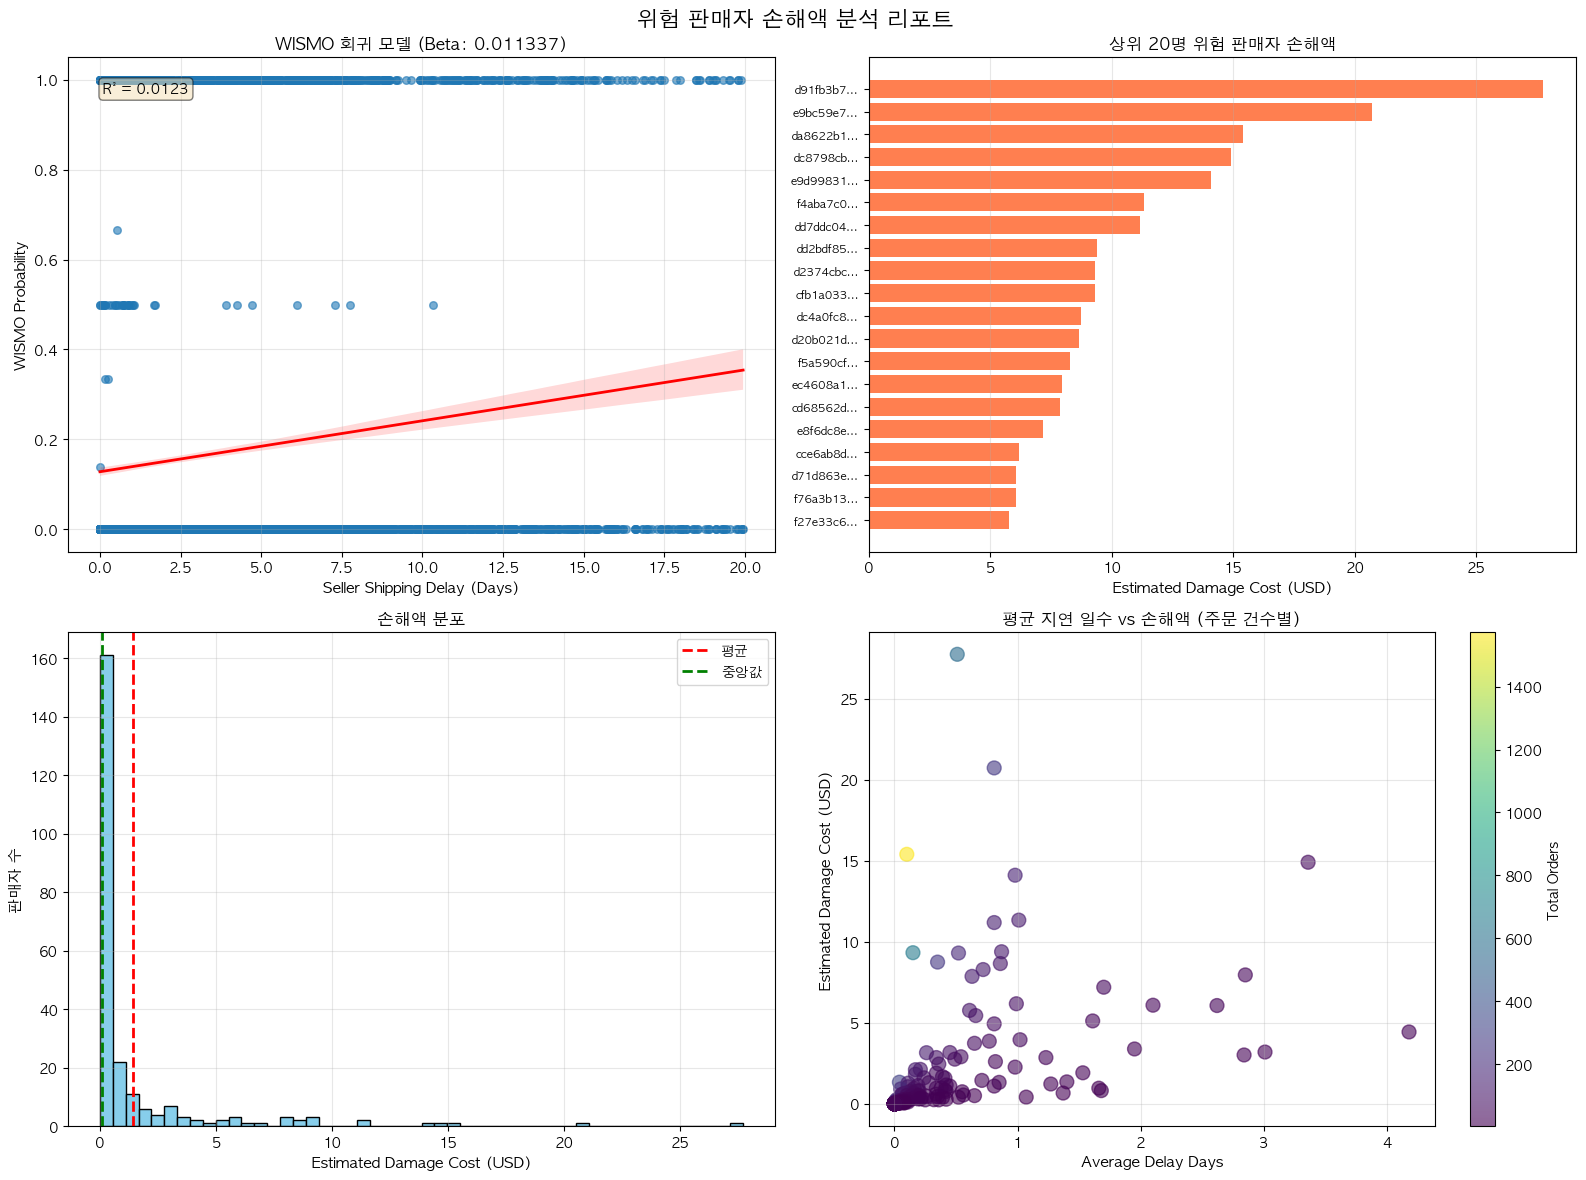

In [77]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('위험 판매자 손해액 분석 리포트', fontsize=16, fontweight='bold')

# (1) WISMO 회귀 모델
ax1 = axes[0, 0]
sns.regplot(
    x='delay_days', 
    y='is_wismo', 
    data=reg_data, 
    scatter_kws={'s': 30, 'alpha': 0.6}, 
    line_kws={'color': 'red', 'linewidth': 2},
    ax=ax1
)
ax1.set_title(f'WISMO 회귀 모델 (Beta: {beta:.6f})', fontsize=12, fontweight='bold')
ax1.set_xlabel('Seller Shipping Delay (Days)', fontsize=11)
ax1.set_ylabel('WISMO Probability', fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.text(0.05, 0.95, f'R² = {r_squared:.4f}', 
         transform=ax1.transAxes, fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# (2) 판매자별 손해액 (상위 20명)
ax2 = axes[0, 1]
top20 = seller_damage_df.head(20)
bars = ax2.barh(range(len(top20)), top20['estimated_damage_cost_usd'], color='coral')
ax2.set_yticks(range(len(top20)))
ax2.set_yticklabels(top20['seller_id'].str[:8] + '...', fontsize=8)
ax2.set_xlabel('Estimated Damage Cost (USD)', fontsize=11)
ax2.set_title('상위 20명 위험 판매자 손해액', fontsize=12, fontweight='bold')
ax2.invert_yaxis()
ax2.grid(axis='x', alpha=0.3)

# (3) 손해액 분포
ax3 = axes[1, 0]
ax3.hist(seller_damage_df['estimated_damage_cost_usd'], bins=50, color='skyblue', edgecolor='black')
ax3.set_xlabel('Estimated Damage Cost (USD)', fontsize=11)
ax3.set_ylabel('판매자 수', fontsize=11)
ax3.set_title('손해액 분포', fontsize=12, fontweight='bold')
ax3.axvline(seller_damage_df['estimated_damage_cost_usd'].mean(), 
            color='red', linestyle='--', linewidth=2, label='평균')
ax3.axvline(seller_damage_df['estimated_damage_cost_usd'].median(), 
            color='green', linestyle='--', linewidth=2, label='중앙값')
ax3.legend()
ax3.grid(True, alpha=0.3)

# (4) 평균 지연 일수 vs 손해액
ax4 = axes[1, 1]
scatter = ax4.scatter(
    seller_damage_df['avg_delay_days'], 
    seller_damage_df['estimated_damage_cost_usd'],
    c=seller_damage_df['total_orders'], 
    cmap='viridis', 
    alpha=0.6, 
    s=100
)
ax4.set_xlabel('Average Delay Days', fontsize=11)
ax4.set_ylabel('Estimated Damage Cost (USD)', fontsize=11)
ax4.set_title('평균 지연 일수 vs 손해액 (주문 건수별)', fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3)
cbar = plt.colorbar(scatter, ax=ax4)
cbar.set_label('Total Orders', fontsize=10)

plt.tight_layout()
plt.savefig('seller_damage_analysis.png', dpi=300, bbox_inches='tight')
print(f"  ✓ 시각화 저장 완료: seller_damage_analysis.png")

plt.show()